In [68]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io.wavfile import write as wavwrite
from scipy.io.wavfile import read as wavread
from scipy.fft import fft,fftfreq,rfft,rfftfreq,irfft
import time
from IPython.display import Audio
import cv2 as cv

#default values 
duration = 1 #seconds
sample_rate = 44100 # samples per second
base = "D:/ENTC/PROJECTS/sp/sp_files/"


#unique file name generator
def unique_file_name(additional_name=""):
    return str(time.time()) + ("_" + additional_name if additional_name else "") 




sample rate: 44100
711601


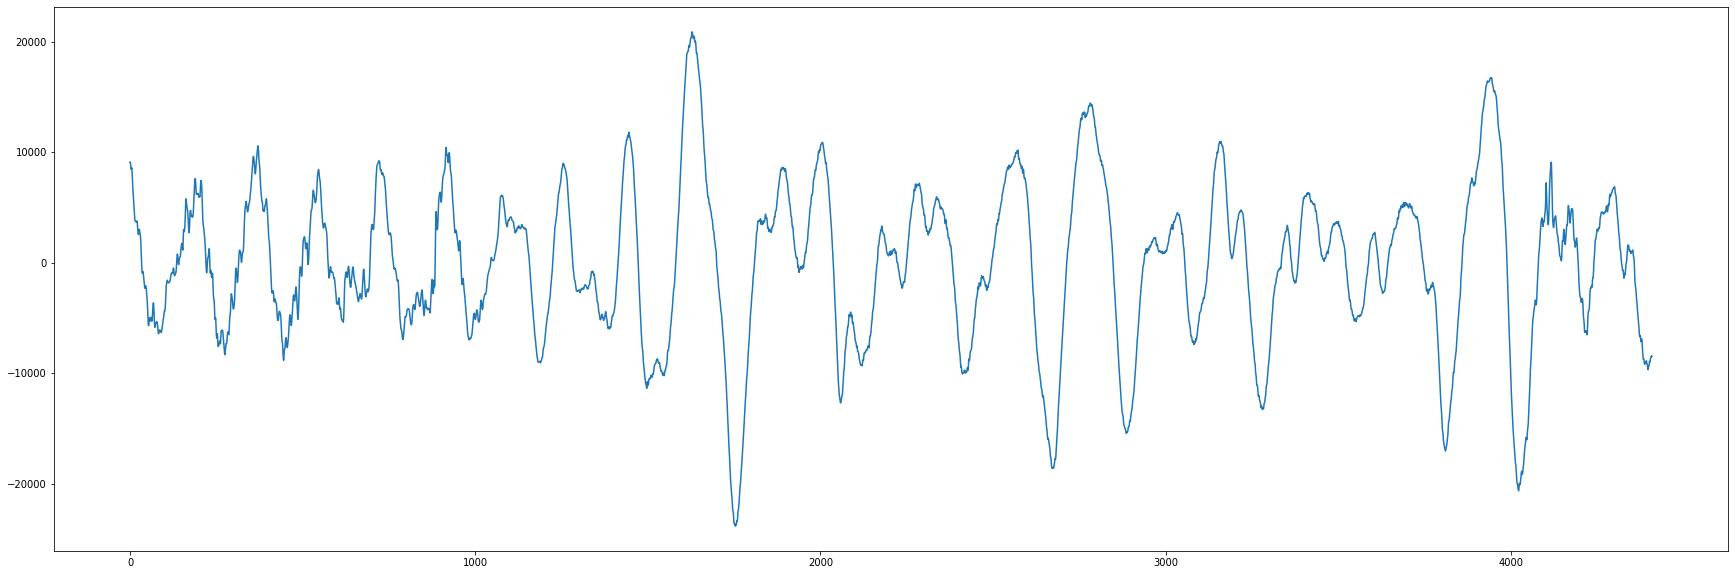

In [2]:
sample_rate , data = wavread(base + "crazy-idea-track-part-01.wav")

#1664982039.3556576.wav  (100Hz+1000Hz sines)
# sample_rate , data = wavread(base + "1664982039.3556576.wav")


#data is a stereo signal --> convert to mono
data = np.average(data,axis=1)
#normalize
data = np.int16(data/np.abs(data).max()*32767)

print("sample rate:",sample_rate)
print(len(data))



fig,ax = plt.subplots(1,figsize=(30,10))
ax.plot(data[:int(sample_rate*0.1)])
plt.show()


In [3]:

filepath = base + "temp/" + unique_file_name() + ".wav"
wavwrite(filepath,sample_rate,data[:int(sample_rate*0.01)])
Audio(filepath, autoplay=True)
    


## Getting the Fourier domain for a small windowed "chunk"

### test 01 : Rectangular window with no overlap between each window

711601


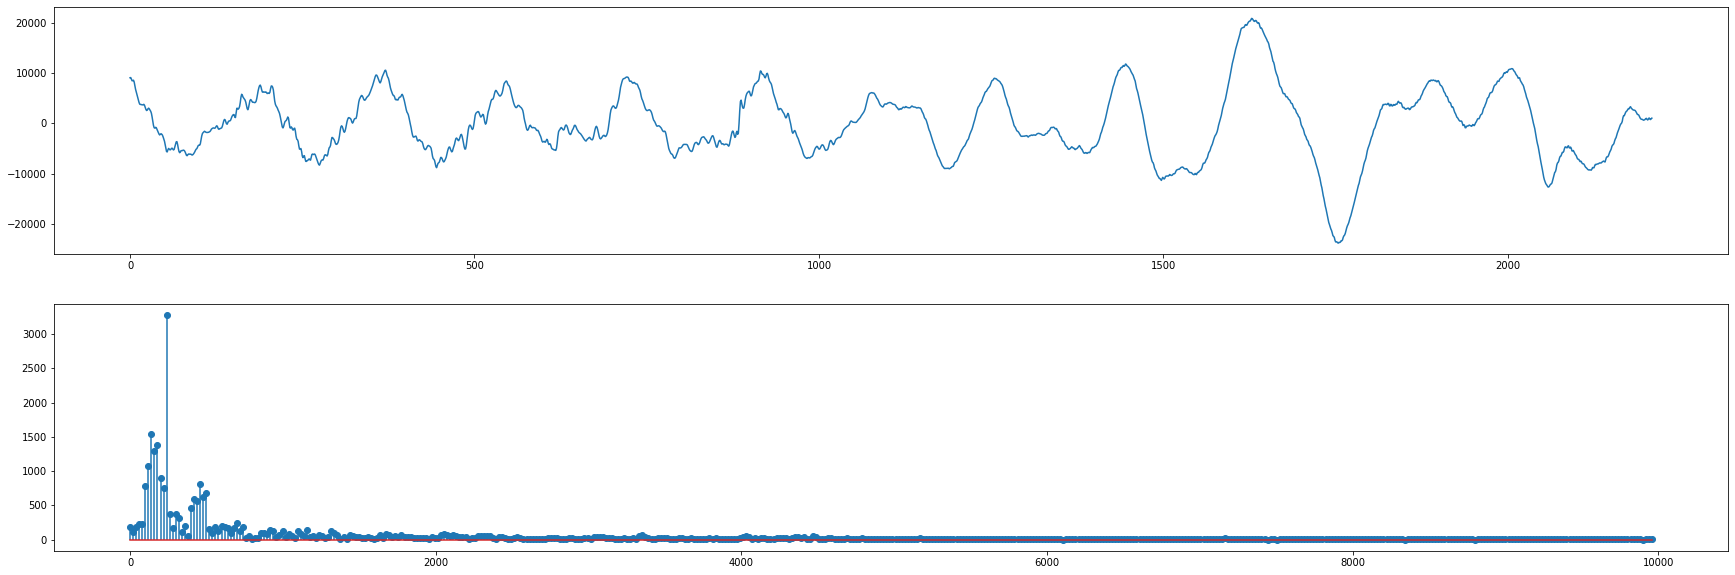

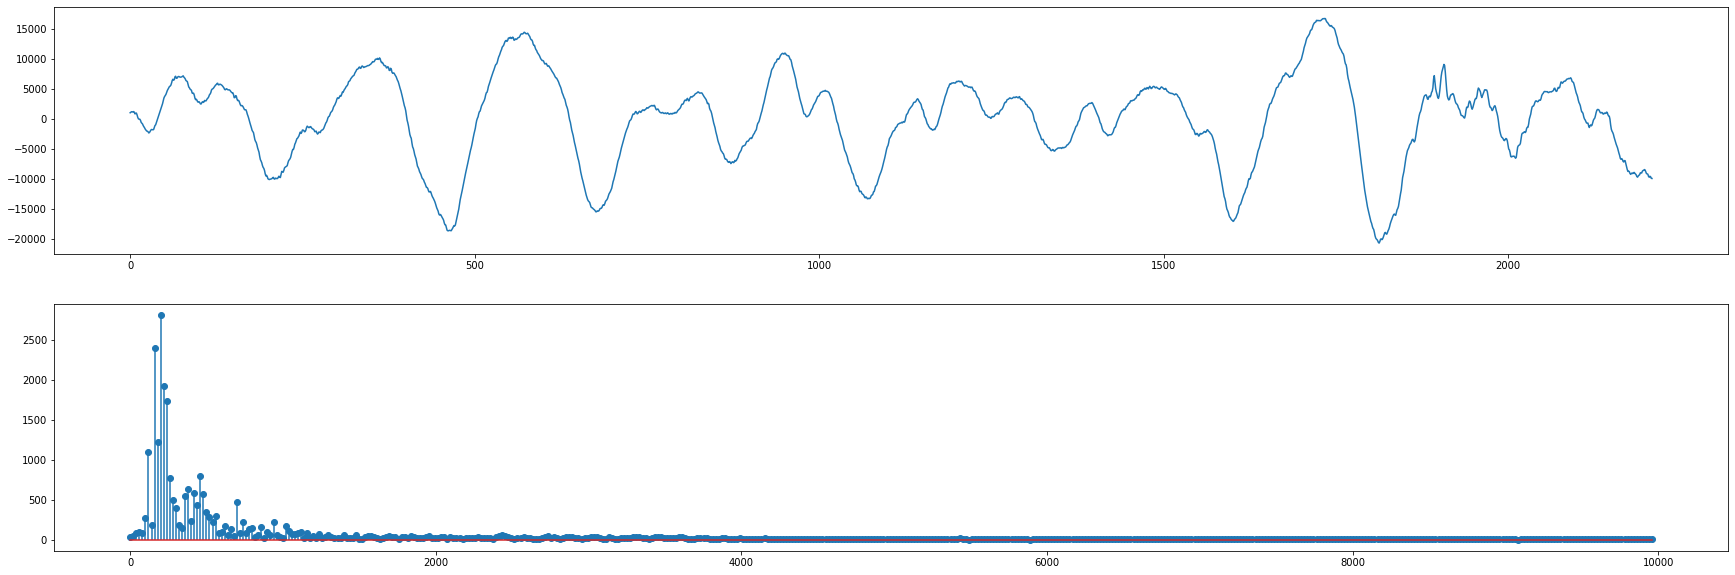

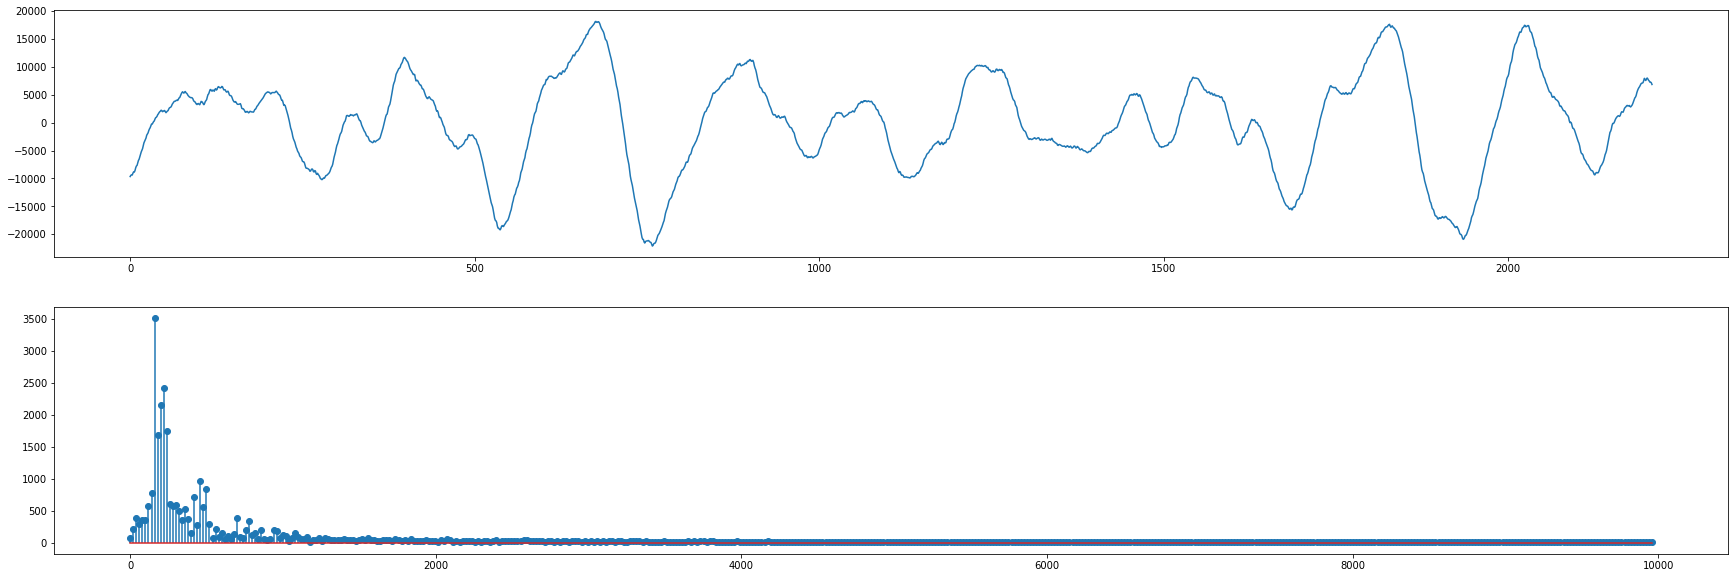

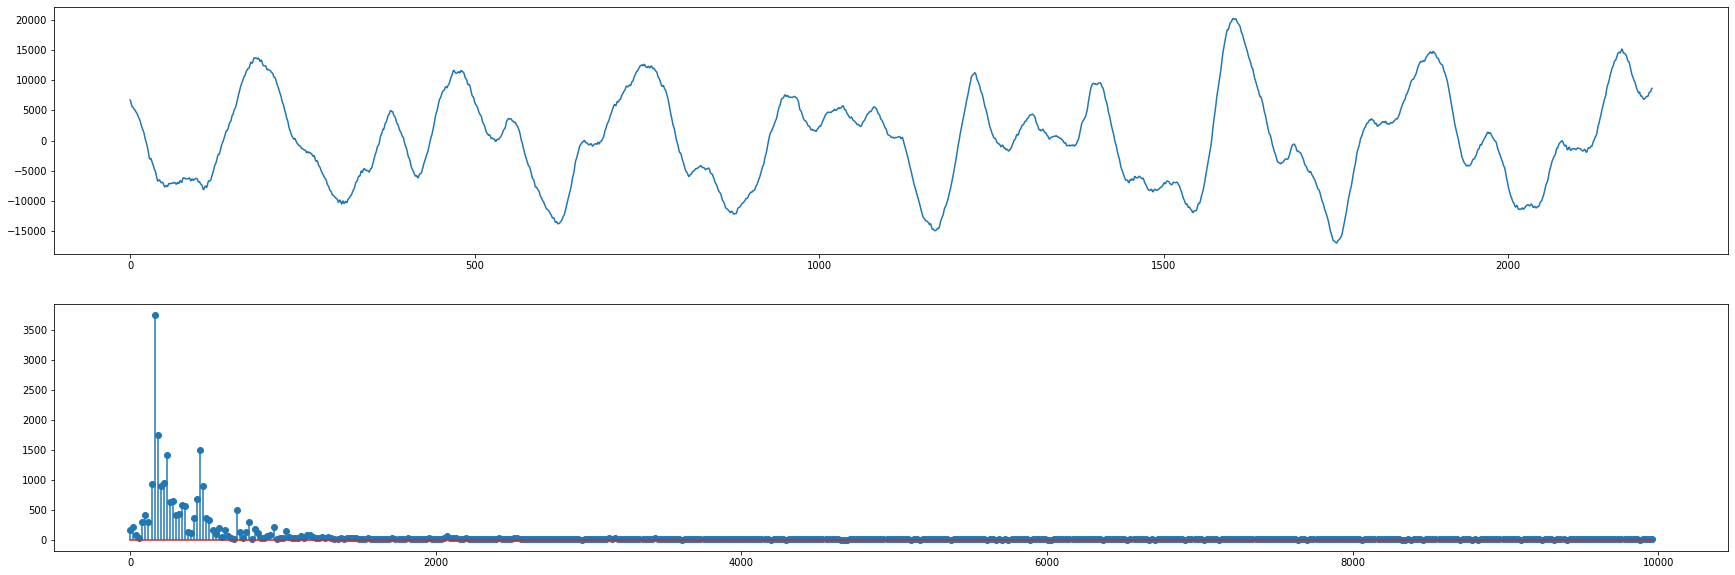

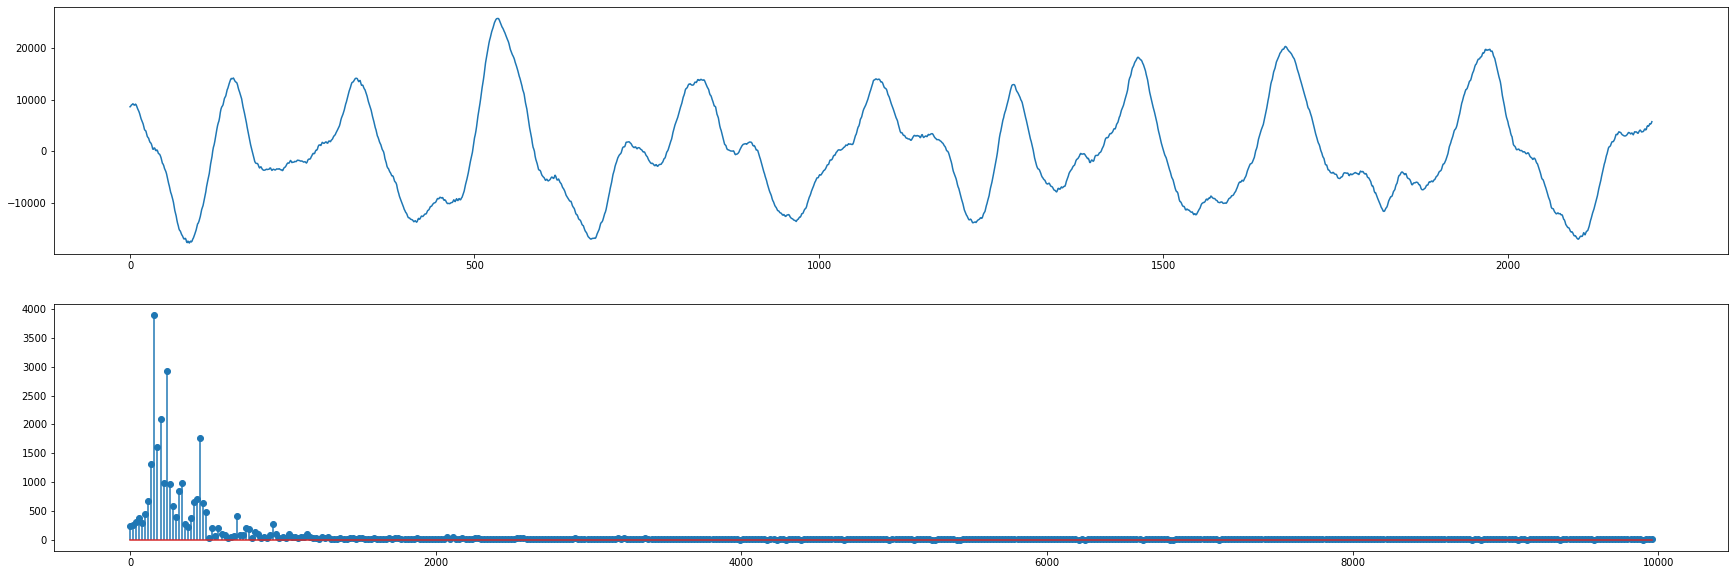

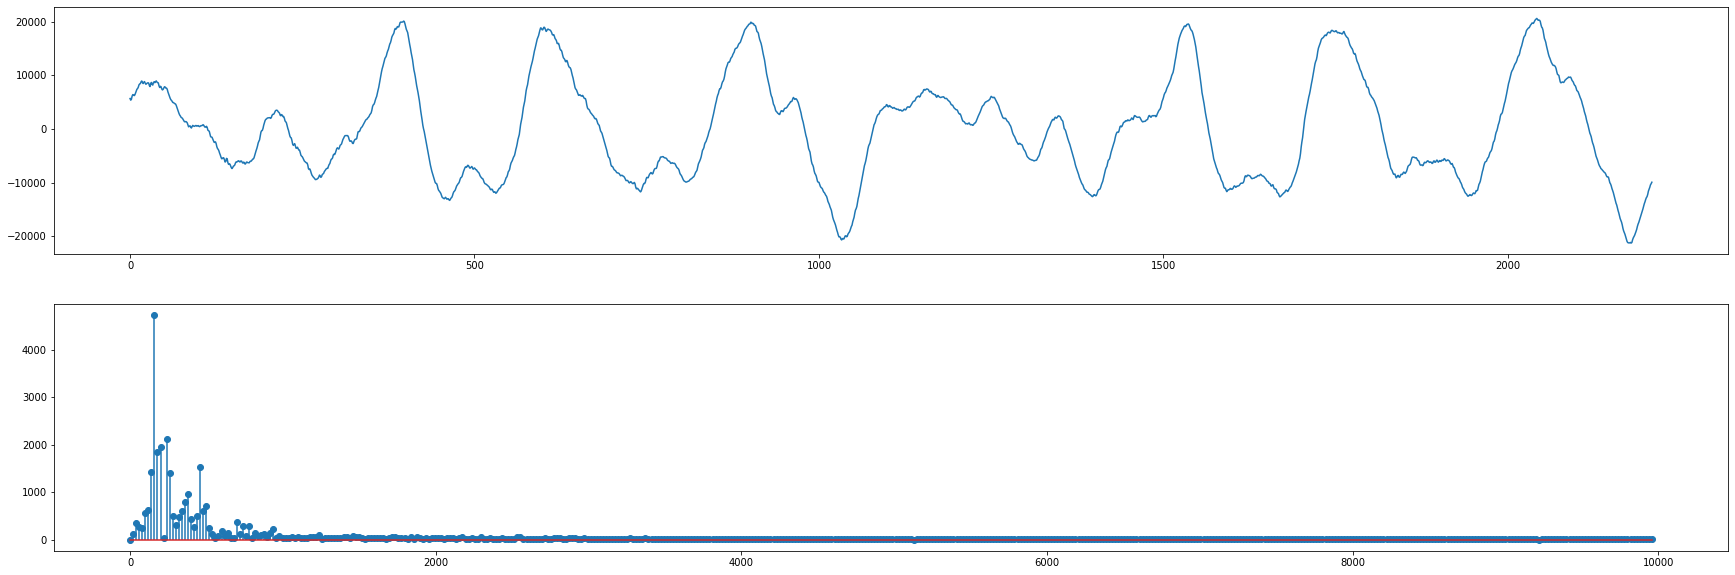

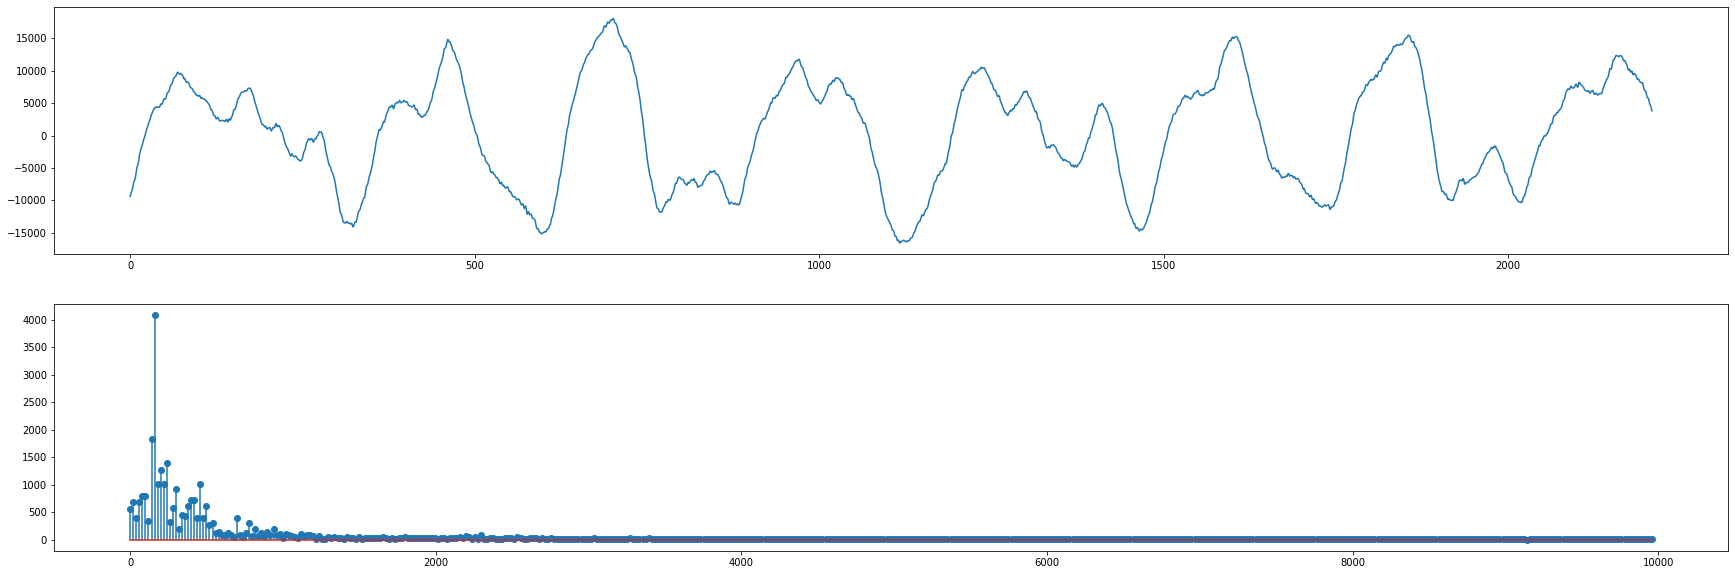

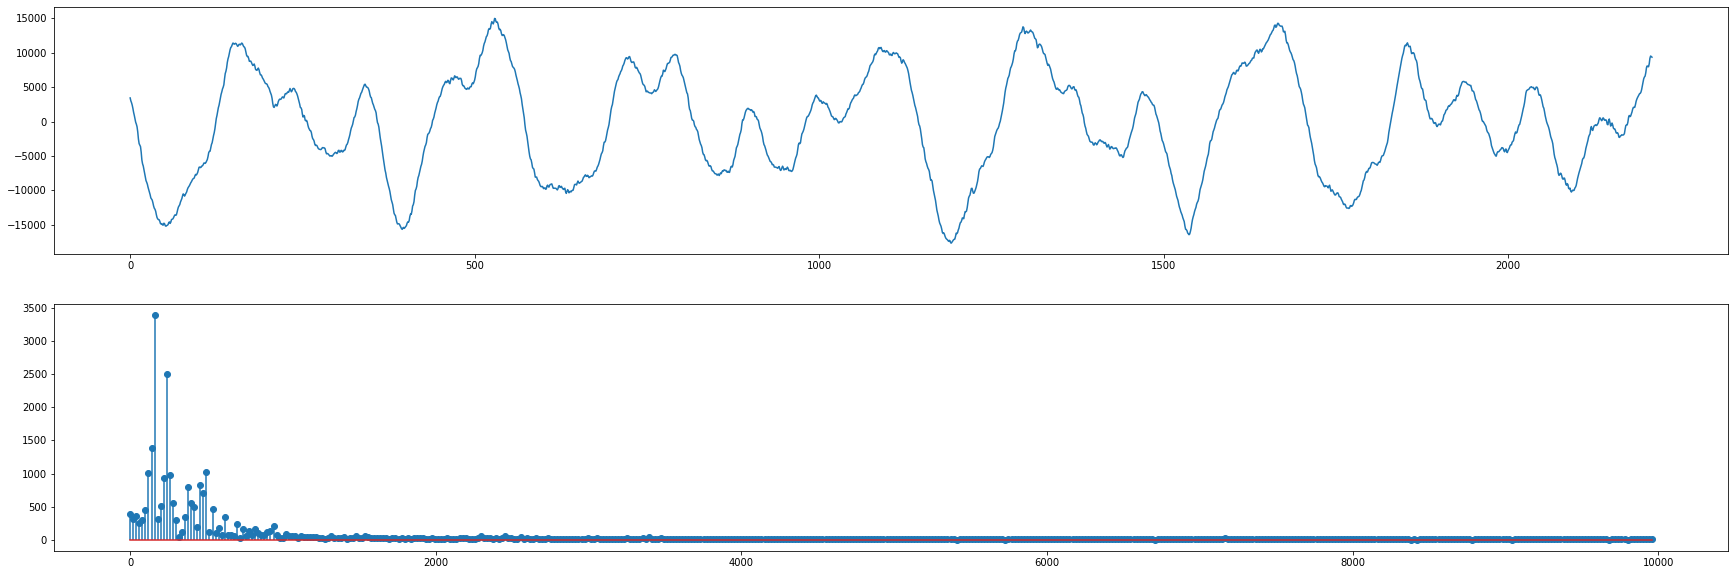

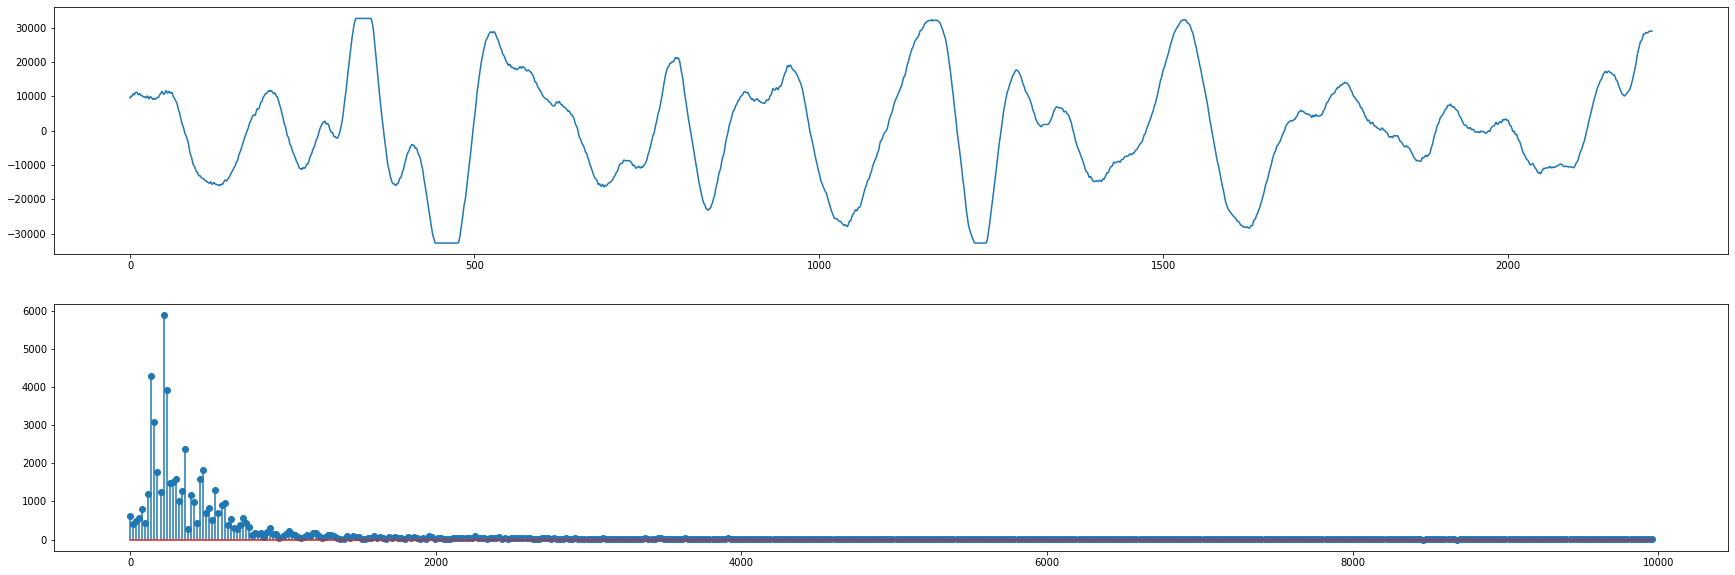

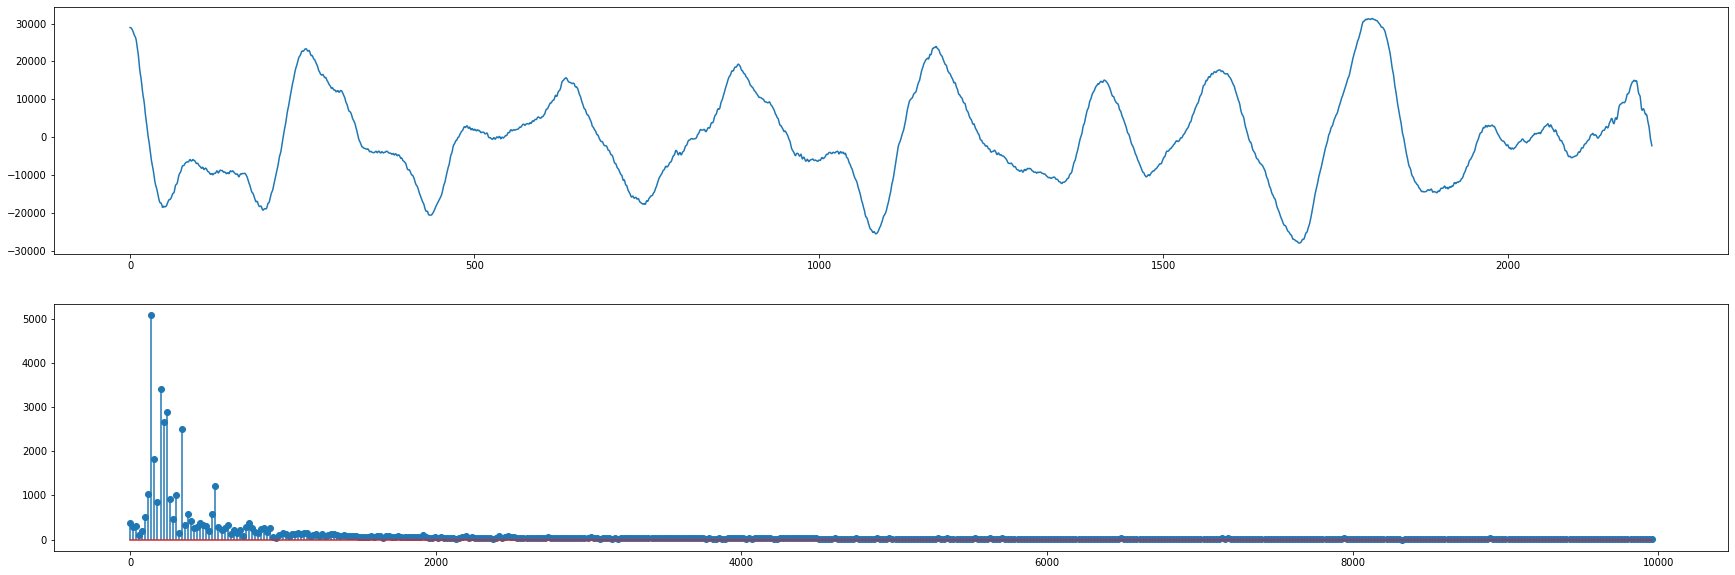

In [7]:
print(len(data))

splitted_data = np.array_split(data,len(data)//(sample_rate*0.05))
len(splitted_data)


for i in range(len(splitted_data))[:10]:
    chunk = splitted_data[i]
    
    N = len(chunk) # number of samples in the time domain signal

    yf = rfft(chunk) #yf = FT_coef * N in that frequency (i.e. to get FT coef , devide by N)
    xf = rfftfreq(N,1/sample_rate) #N=number of samples in time domain, <2nd_arg> = time gap between 2 samples
    
    
    fig,ax = plt.subplots(2,figsize=(30,10))
    ax[0].plot(chunk)
    ax[1].stem(xf[:500],np.abs(yf/N)[:500])
    plt.show()



## Generating windows (time shifted) with length of a given array

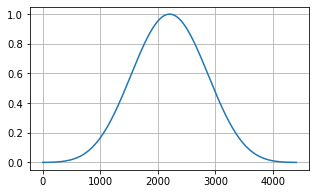

In [16]:
chunk_length_in_seconds = 0.1

#Blackman Nuttal window
window_N = sample_rate * chunk_length_in_seconds
window_N = int(window_N)

a0,a1,a2,a3 = 0.3635819,0.4891775,0.1365995,0.0106411
xWindow = np.arange(0,window_N,1)
yWindow = a0 - a1 * np.cos(2 * np.pi * xWindow  / window_N) + a2 * np.cos(4 * np.pi * xWindow  / window_N) -a3 * np.cos(6 * np.pi * xWindow  / window_N)


fig,ax = plt.subplots(1,figsize=(5,3))
ax.plot(xWindow,yWindow)
ax.grid()
plt.show()

r3:shape (159, 711601)


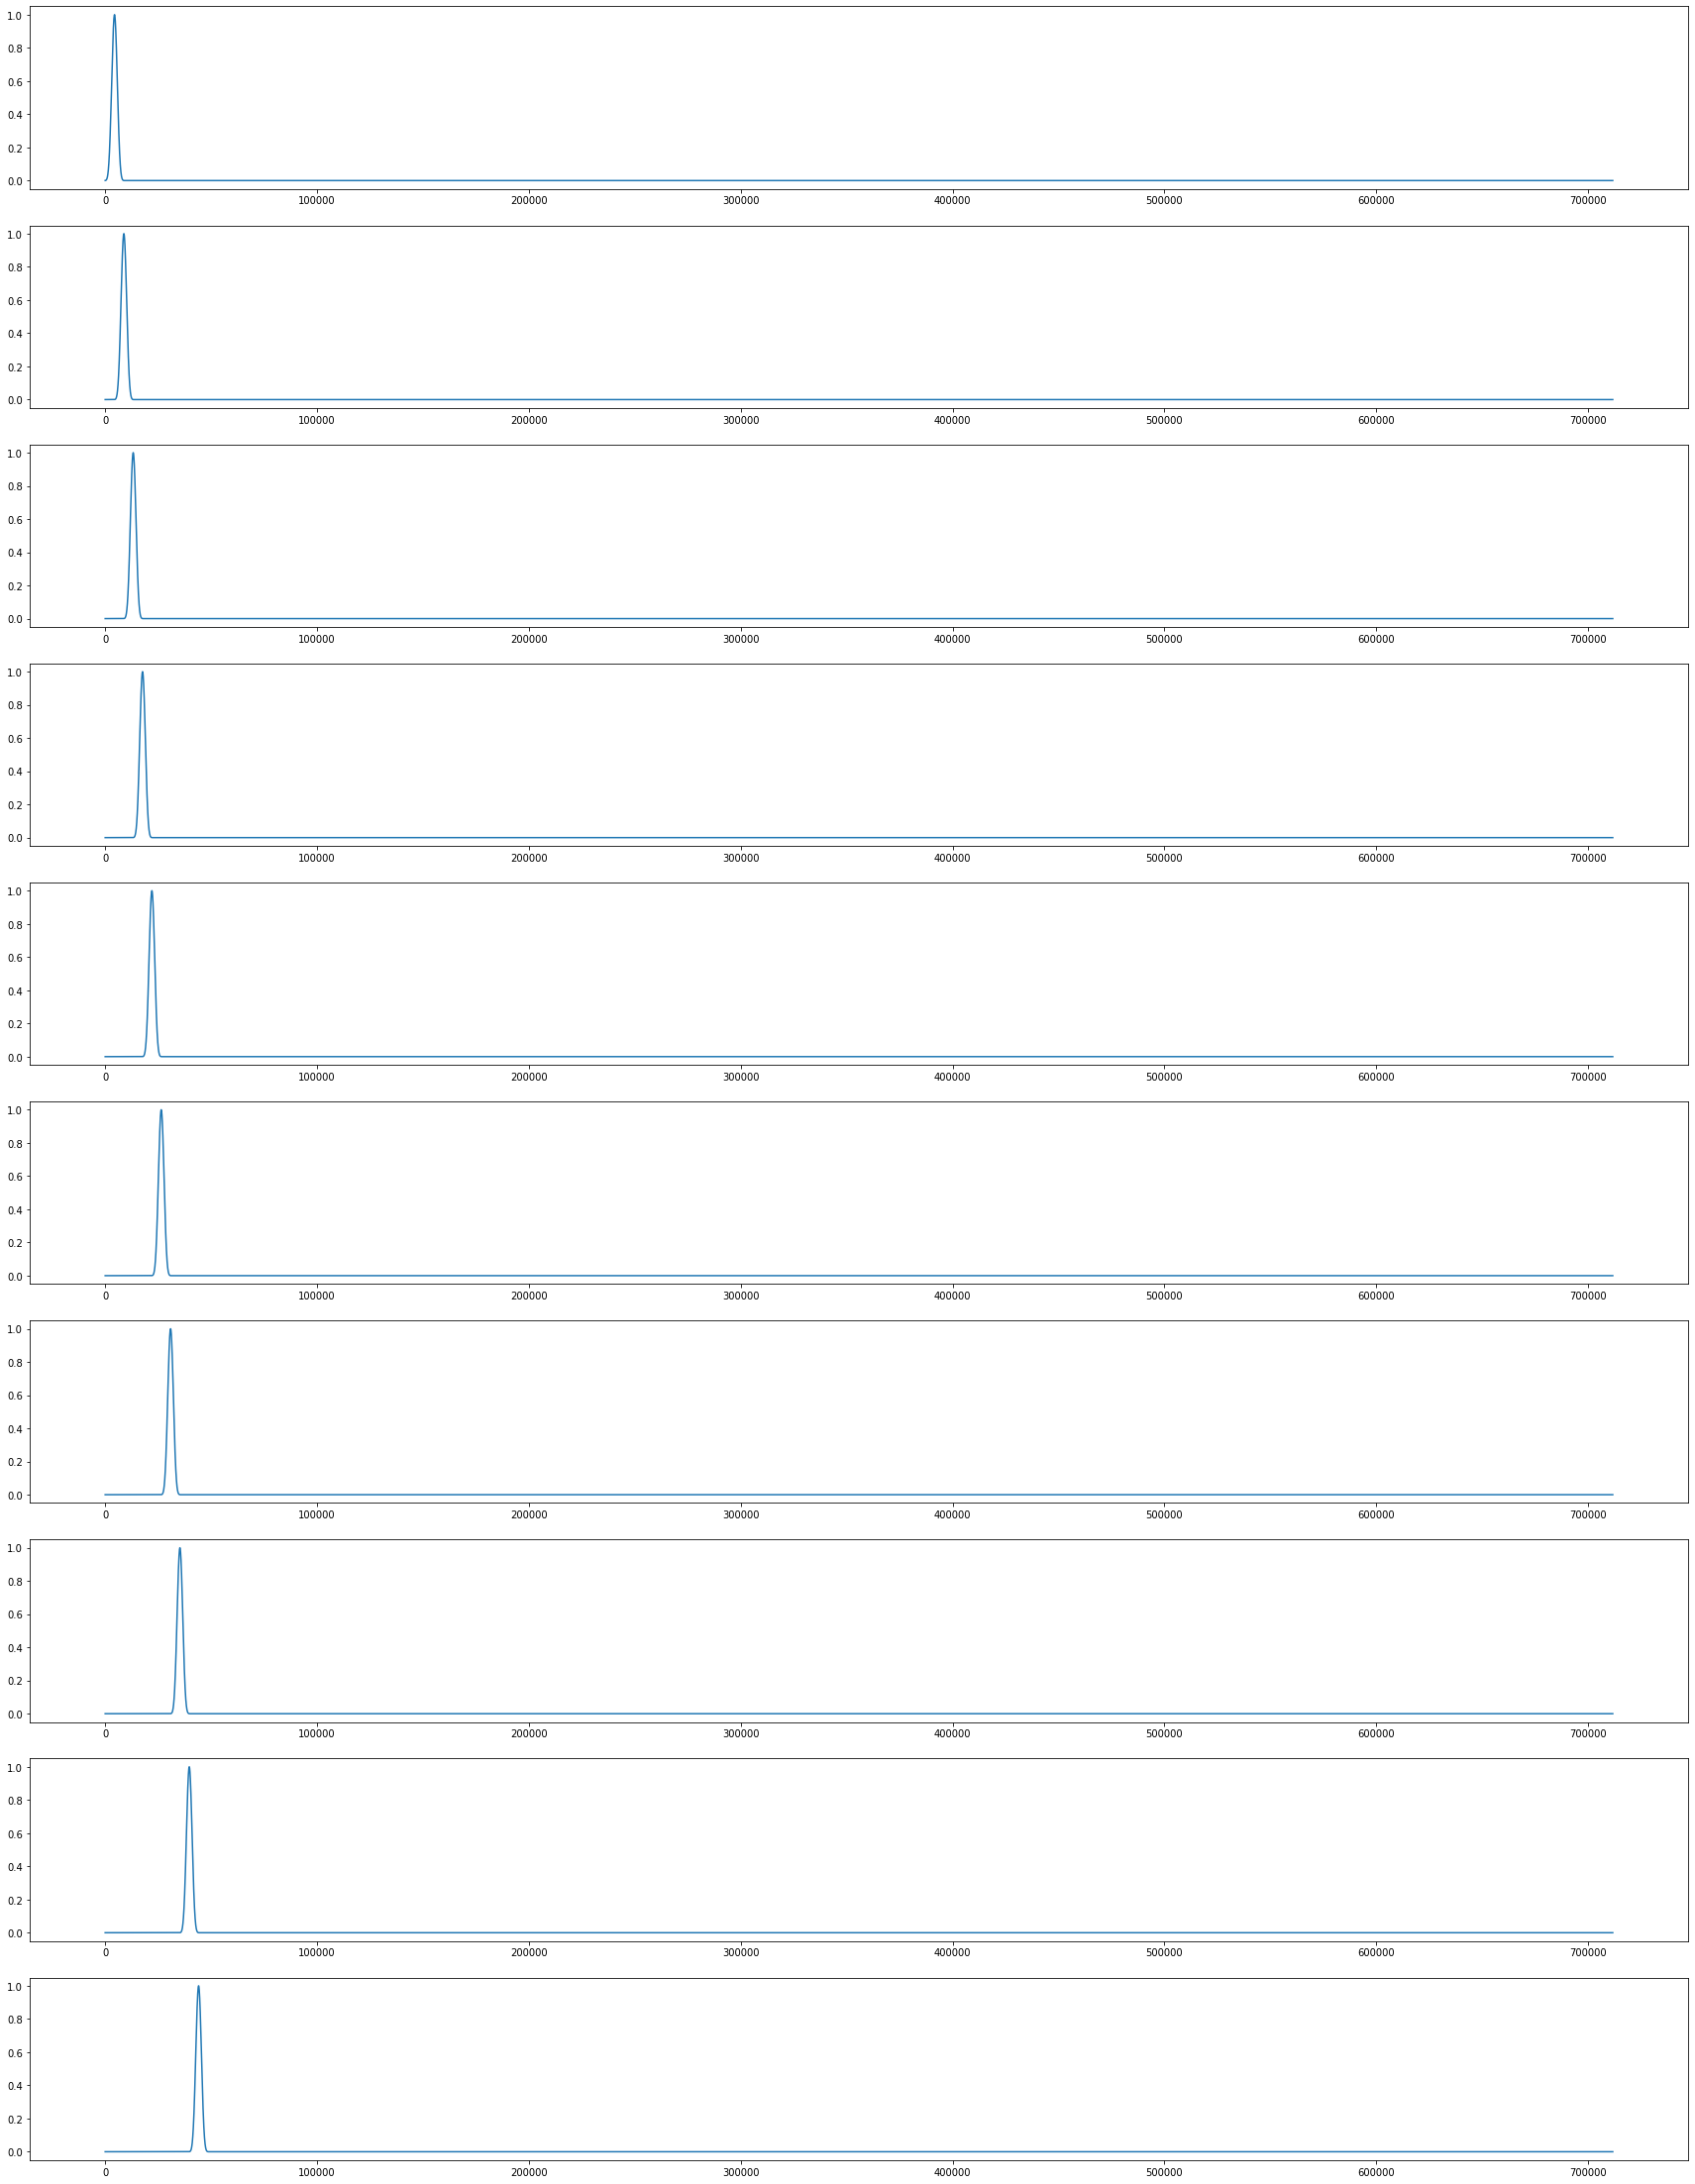

In [45]:
#making a "array of properly shifted windows" to target each "target point" in a given "main signal"
spacing = 0.1 # seconds
window_dura = 0.2 #seconds

signal_N = len(data) #length of whole audio

window_N = int(sample_rate * window_dura)
spacing_N = int(spacing * sample_rate)

#blackman nuttel window
a0,a1,a2,a3 = 0.3635819,0.4891775,0.1365995,0.0106411
xWindow = np.arange(0,window_N,1)
yWindow = a0 - a1 * np.cos(2 * np.pi * xWindow  / window_N) + a2 * np.cos(4 * np.pi * xWindow  / window_N) -a3 * np.cos(6 * np.pi * xWindow  / window_N)


n = int((signal_N - window_N) / spacing_N) # number of chunks targetable (window touches the starting point
                                                # ... total does not exceed signal length)
    
window_Array = np.zeros(shape=(n,siganl_N)) # all windows horizontally stacked
print("r3:shape",window_Array.shape)
for i in range(n):
    window_Array[i,i*spacing_N:i*spacing_N+window_N] = yWindow
    
    
    
#See how the window_Array's each "window with full duration" looks like
max_plot_N = 10
fig,ax = plt.subplots(min(max_plot_N,n),1,figsize=(30,4*min(max_plot_N,n)))
for i in range(n)[:max_plot_N]:
    ax[i].plot(window_Array[i])
plt.show()



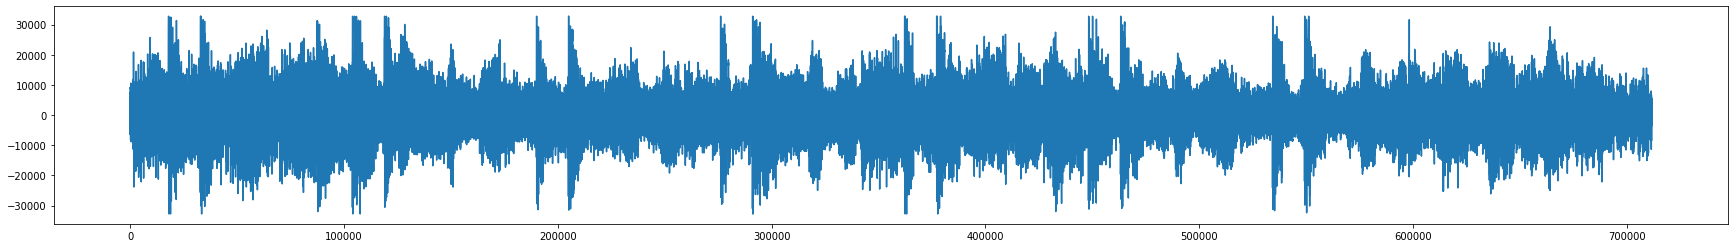

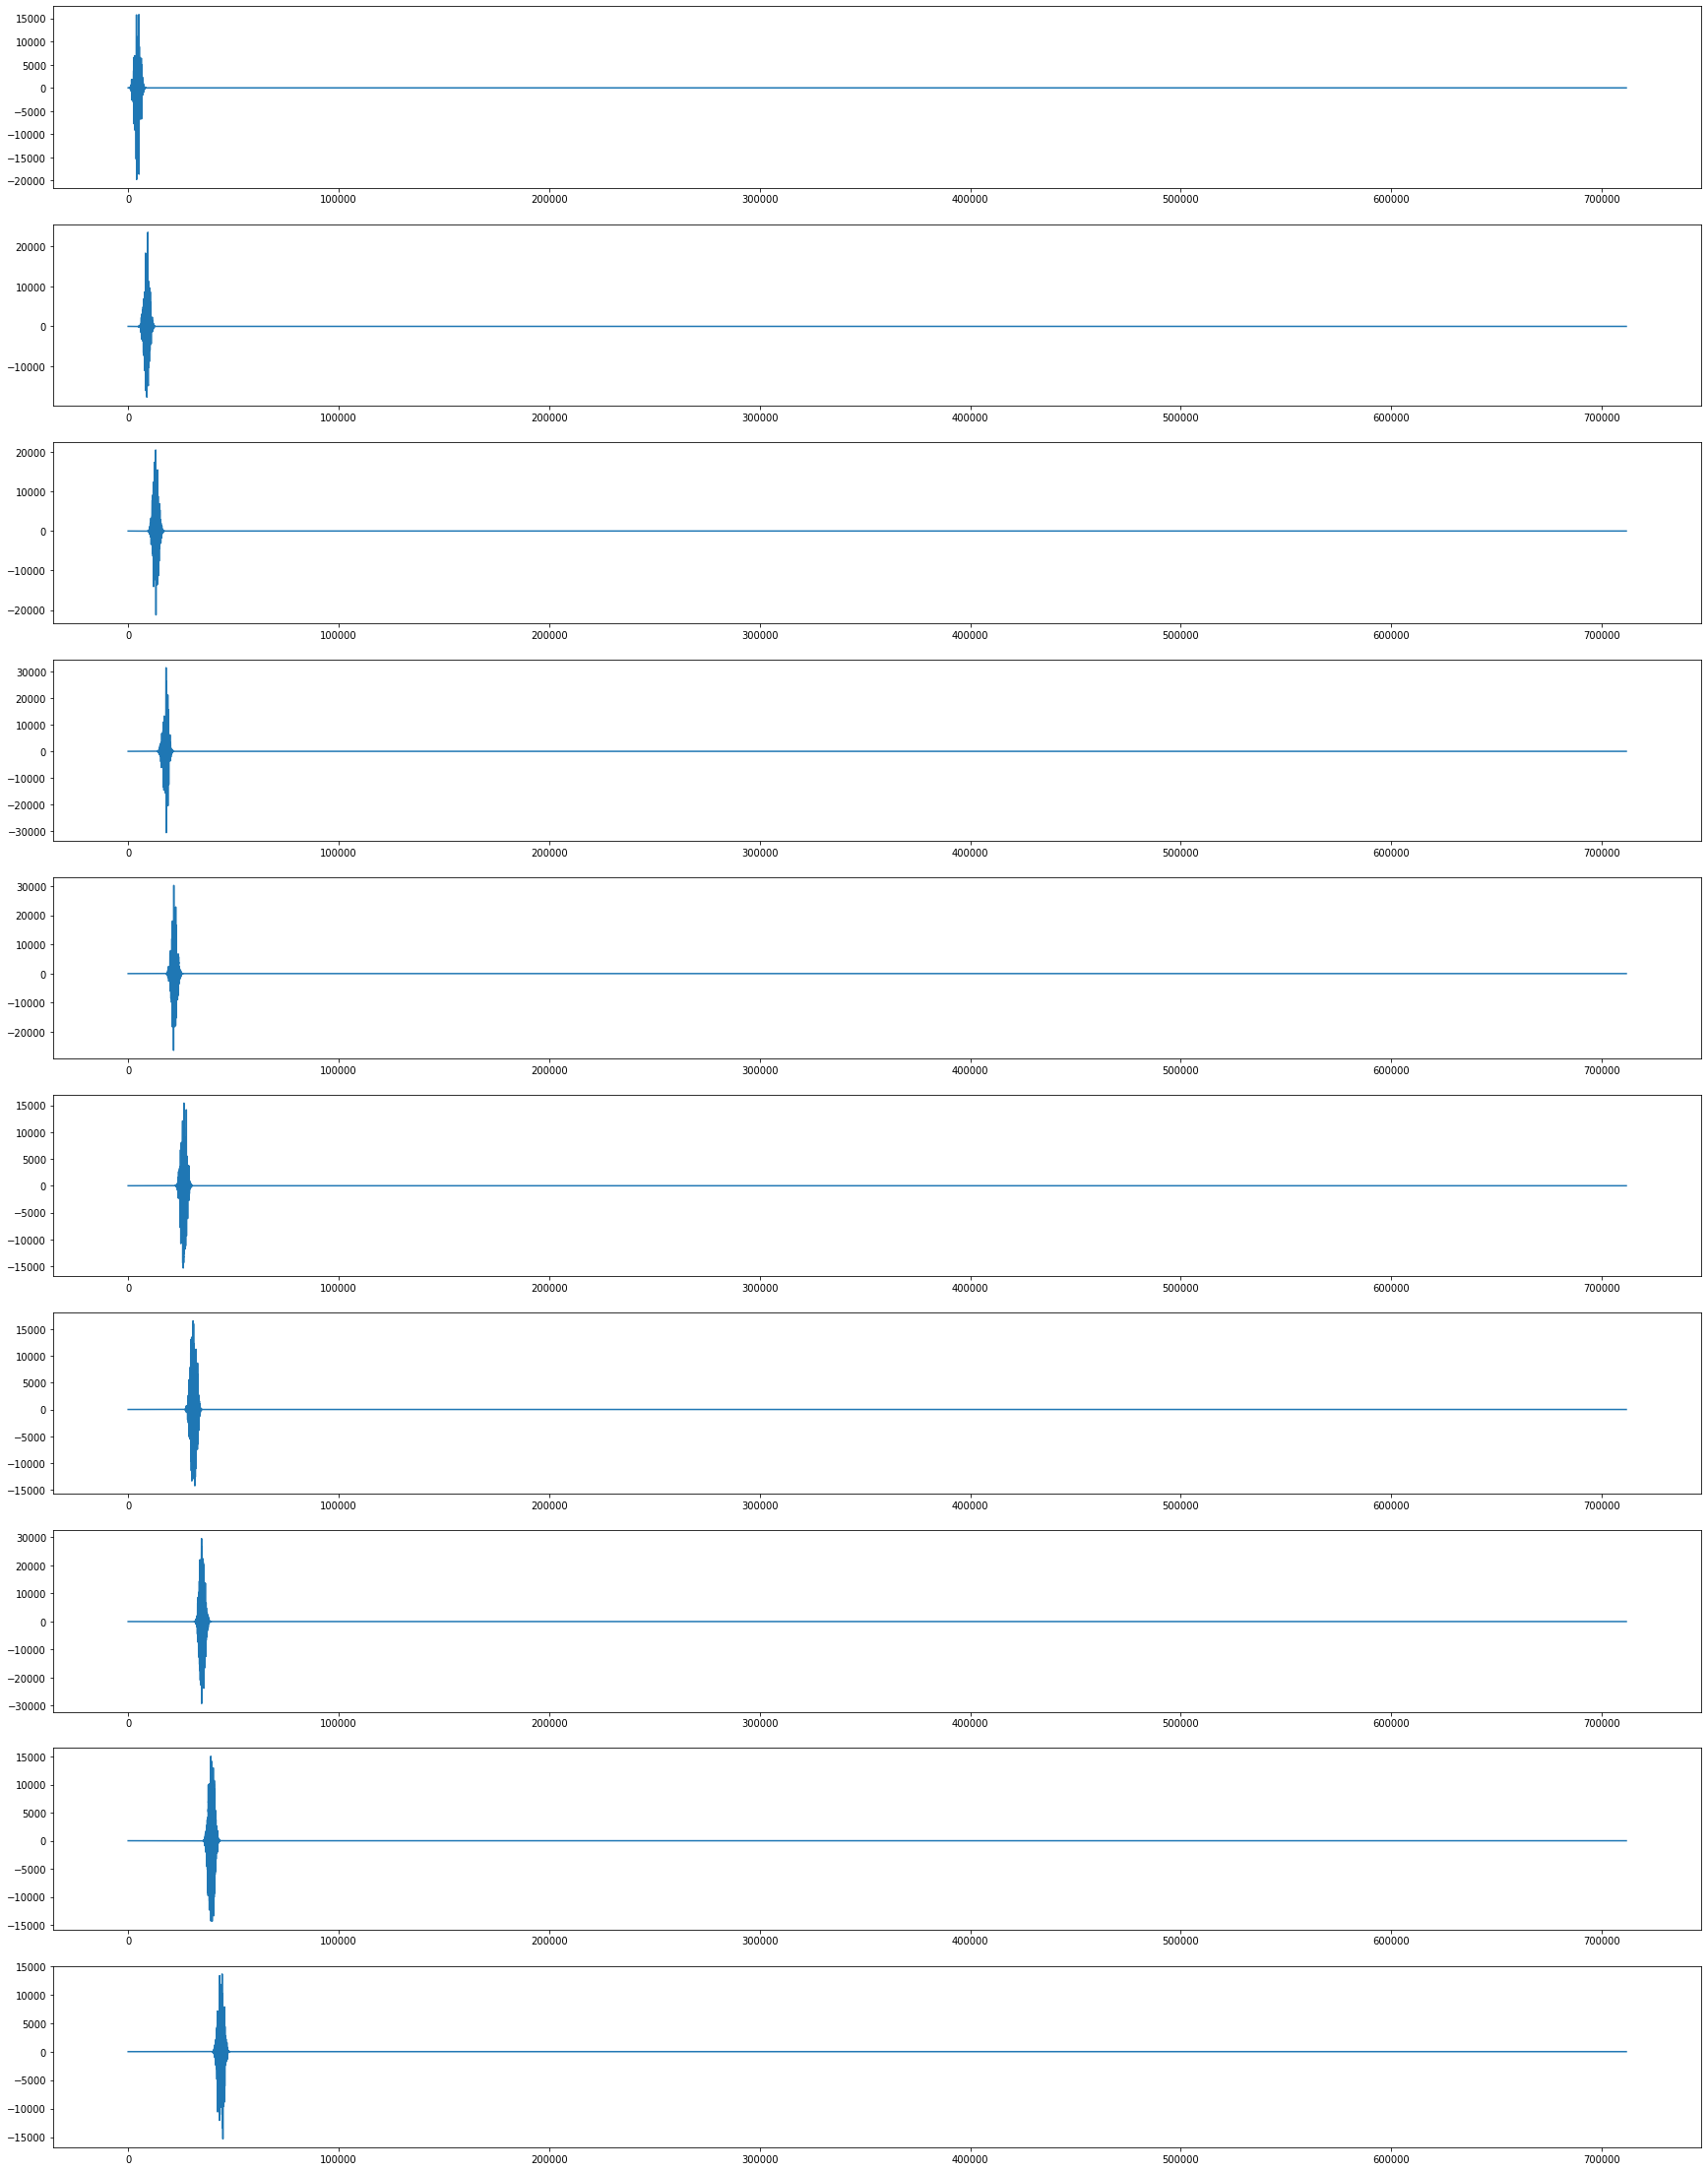

In [50]:
#windowed chunck array (these chunks has the duration of full audio signal)
windowed_chunks_withZeros = data * window_Array

#see how the original audio looks like
fig,ax = plt.subplots(1,1,figsize=(30,4))
ax.plot(data)
plt.show()

#See how the window_Array's each "windowed chunk with full duration" looks like
max_plot_N = 10
fig,ax = plt.subplots(min(max_plot_N,n),1,figsize=(30,4*min(max_plot_N,n)))
for i in range(n)[:max_plot_N]:
    ax[i].plot(windowed_chunks_withZeros[i])
plt.show()

### Results / comments

Slow!\
The intermediate signals are padded with zeros --> too many calculation because numpy does waste time for zero multiplications also.\
So let's do a simple loop!

##  Second attempt - using a simple loop

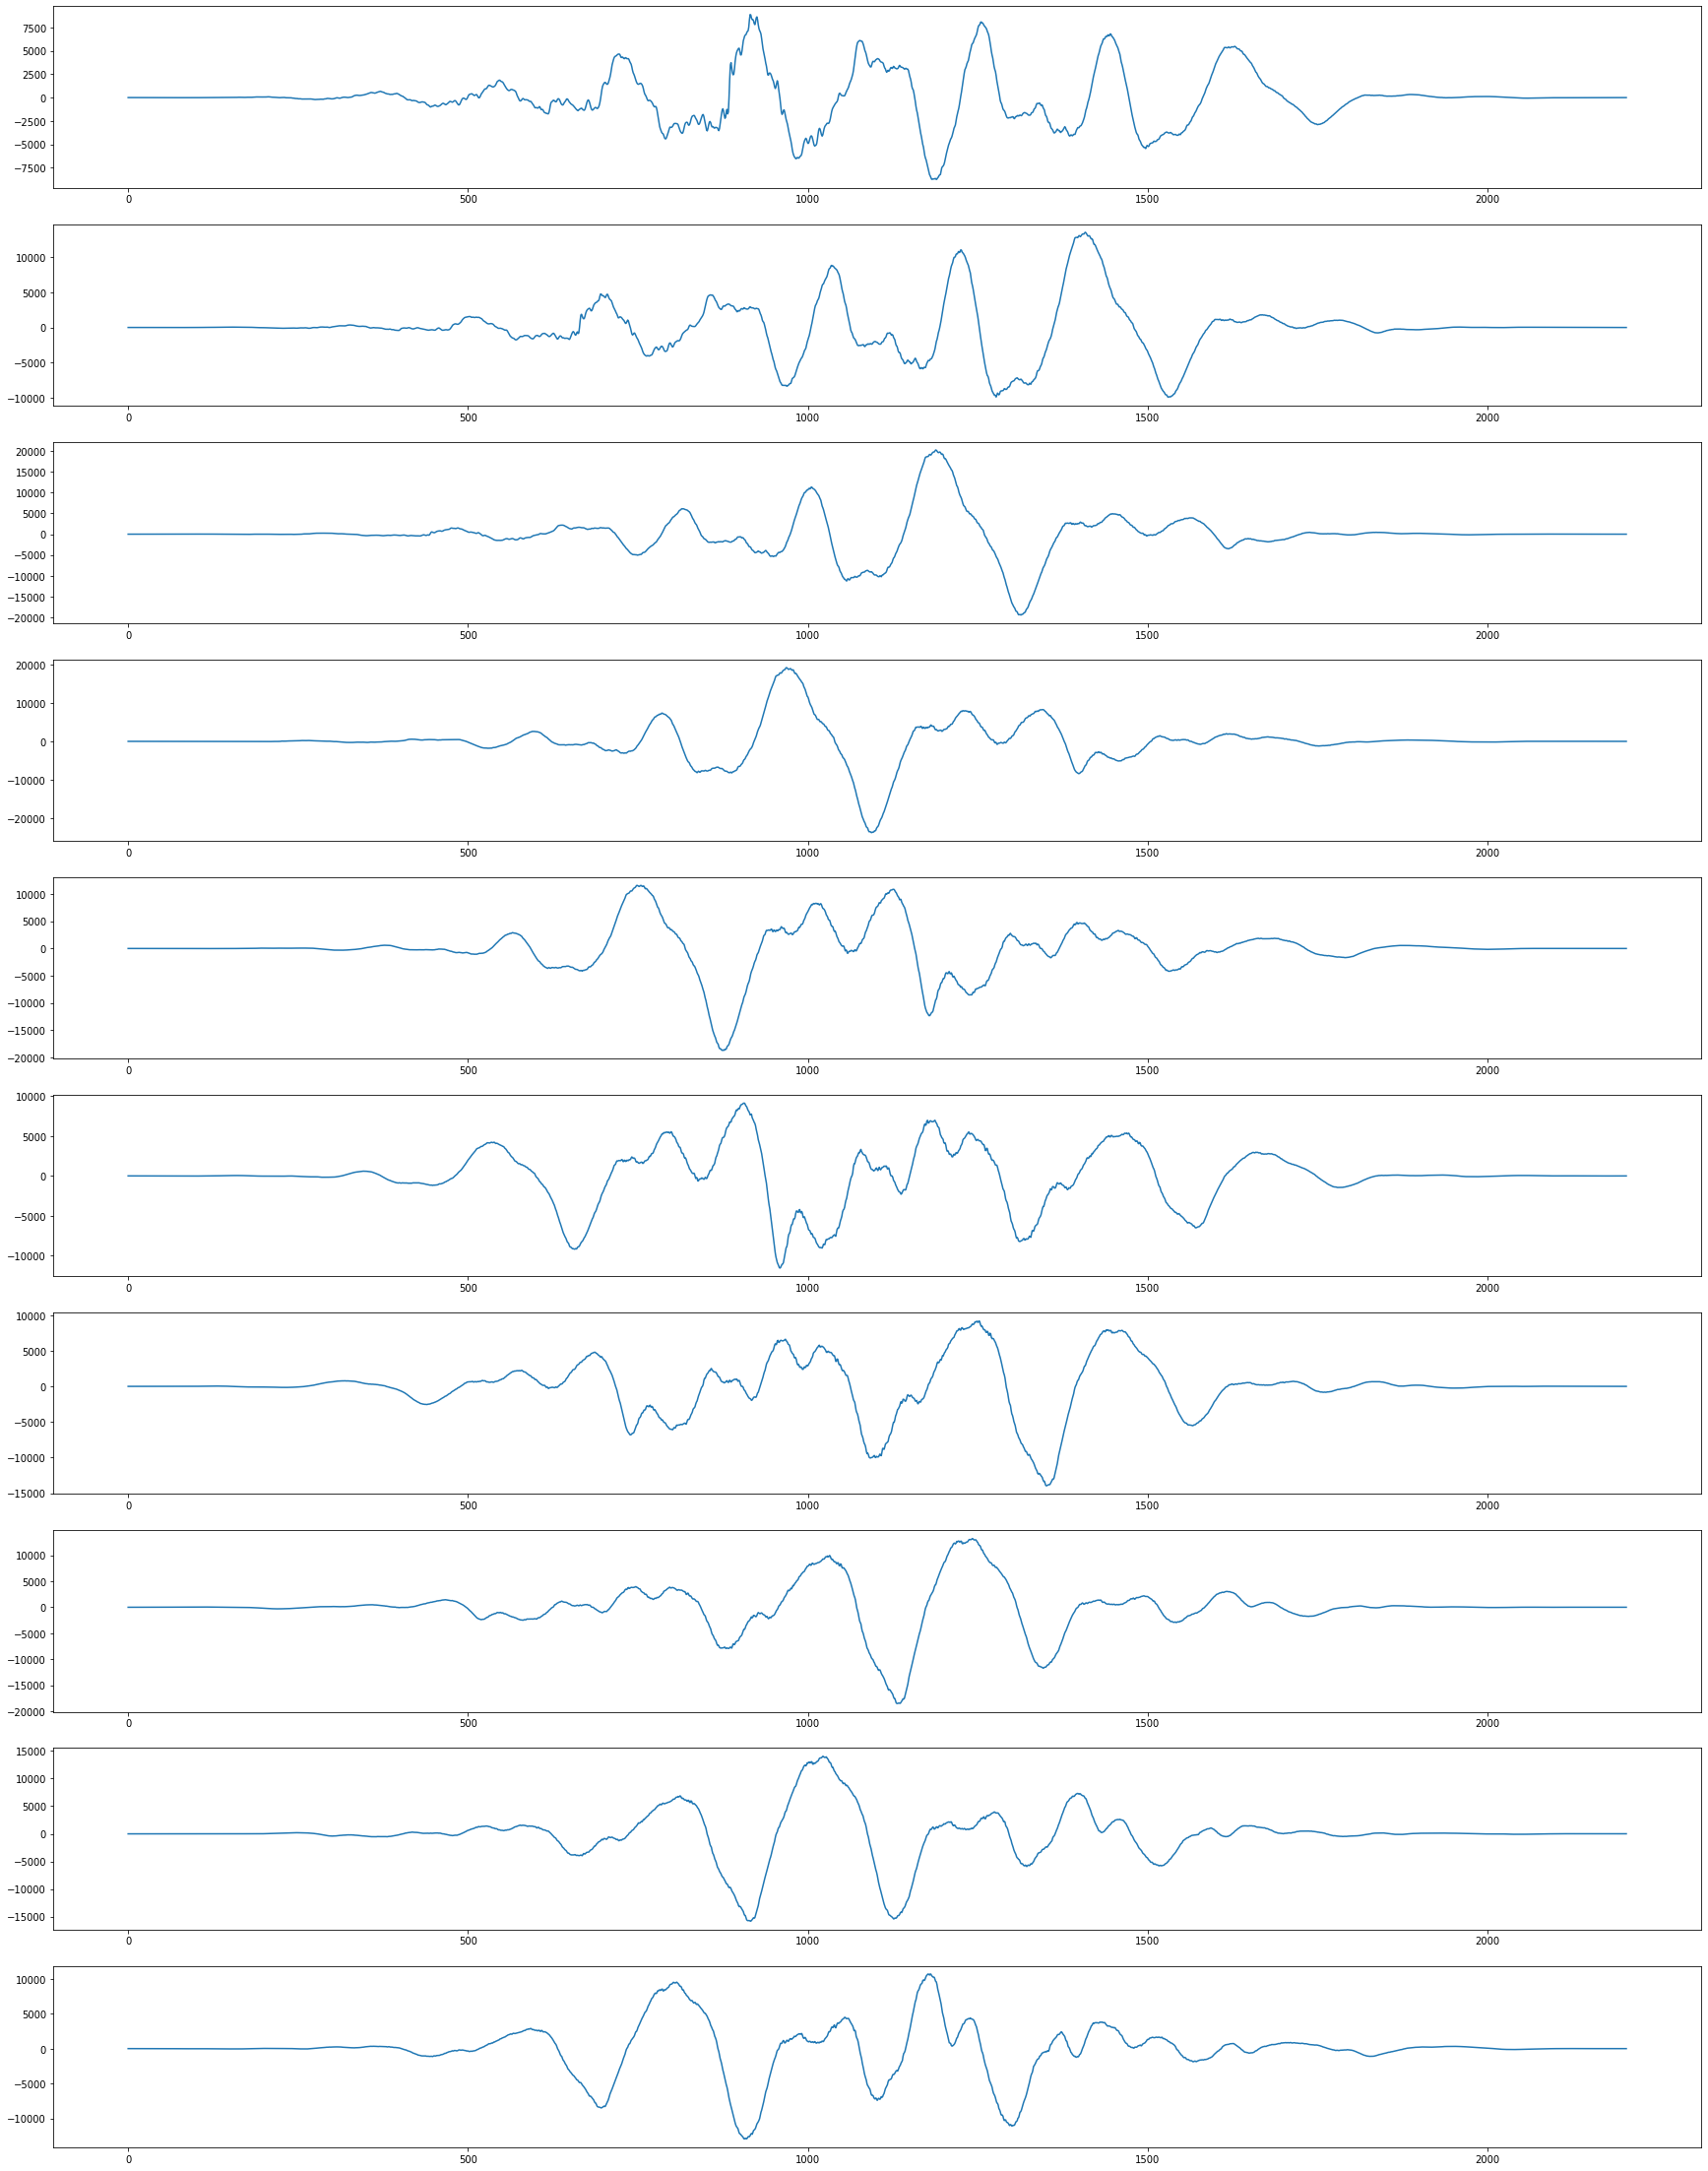

In [113]:

spacing = 0.005 # seconds
window_dura = 0.05 #seconds

signal_N = len(data) #length of whole audio

window_N = int(sample_rate * window_dura)
spacing_N = int(spacing * sample_rate)

#blackman nuttel window
a0,a1,a2,a3 = 0.3635819,0.4891775,0.1365995,0.0106411
xWindow = np.arange(0,window_N,1)
yWindow = a0 - a1 * np.cos(2 * np.pi * xWindow  / window_N) + a2 * np.cos(4 * np.pi * xWindow  / window_N) -a3 * np.cos(6 * np.pi * xWindow  / window_N)


n = int((signal_N - window_N) / spacing_N) # number of chunks targetable (window touches the starting point
                                                # ... total does not exceed signal length)
    
signal_chunks = []
for i in range(n):
    signal_chunks.append(data[i*spacing_N:i*spacing_N+window_N])
signal_chunks = np.array(signal_chunks)

windowed_chunks = yWindow * signal_chunks

#See how each windowed chunk looks like
max_plot_N = 10
fig,ax = plt.subplots(min(max_plot_N,n),1,figsize=(30,4*min(max_plot_N,n)))
for i in range(n)[:max_plot_N]:
    ax[i].plot(windowed_chunks[i])
plt.show()
    
    
    

Compared to previous attempt, this is faster. Also we should notice here no unnecessary calculation is done

In [114]:
#CALC and show the fourier transformation
FT_of_chunks = []
for i in range(len(windowed_chunks)):
    chunk = windowed_chunks[i]
    
    N = len(chunk) # number of samples in the time domain signal

    yf = rfft(chunk) #yf = FT_coef * N in that frequency (i.e. to get FT coef , devide by N)
    xf = rfftfreq(N,1/sample_rate) #N=number of samples in time domain, <2nd_arg> = time gap between 2 samples
    
    FT_of_chunks.append(np.abs(yf))
    
#     fig,ax = plt.subplots(2,figsize=(30,10))
#     ax[0].plot(chunk)
#     ax[1].stem(xf[:500],np.abs(yf/N)[:500])
#     plt.show()

    
FT_of_chunks = (np.array(FT_of_chunks)/len(chunk)).astype(np.uint8).T
FT_of_chunks = np.flip(FT_of_chunks,axis=0)

0.005 second spaced Number of chunks:  3224


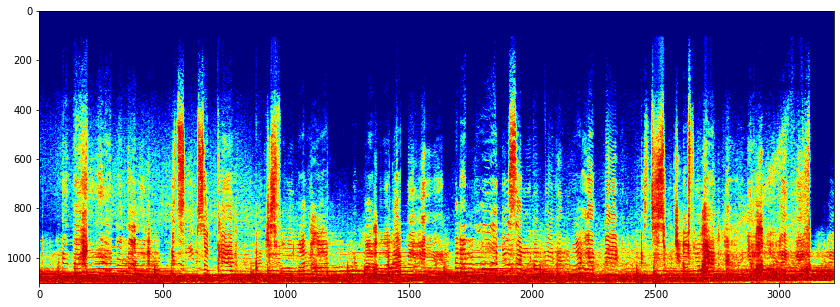

In [115]:
print("{} second spaced Number of chunks: ".format((spacing)) ,len(windowed_chunks))





equalized = cv.equalizeHist(FT_of_chunks)

fig,ax = plt.subplots(1,figsize=(90,5))
ax.imshow(equalized,cmap="jet")




## Results / Comments
Spectrogram looks fine \
A proper understanding on the axis is not really needed to find patterns.But will have a look at it. \
Move to next notebook with basic codes implemented here.
